In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.calibration import CalibratedClassifierCV

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

from get_metrics import get_metrics_classification
import optuna
from tqdm import tqdm_notebook
import warnings
from warnings import simplefilter
warnings.filterwarnings("ignore")
simplefilter("ignore", category=RuntimeWarning)

N_FOLDS = 5
RAND = 10

# Preparing

- country - Country interviewee is in.
- year - Year survey was done in.
- uniqueid - Unique identifier for each interviewee
- location_type	- Type of location: Rural, Urban
- cellphone_access - If interviewee has access to a cellphone: Yes, No
- household_size - Number of people living in one house
- age_of_respondent - The age of the interviewee
- gender_of_respondent - Gender of interviewee: Male, Female
- relationship_with_head - The interviewee’s relationship with the head of the house:Head of Household, Spouse, Child, Parent, Other relative, Other non-relatives, Don't know
- marital_status - The martial status of the interviewee: Married/Living together, Divorced/Seperated, Widowed, Single/Never Married, Don't know
- education_level - Highest level of education: No formal education, Primary education, Secondary education, Vocational/Specialised training, Tertiary education, Other/Dont know/RTA
- job_type - Type of job interviewee has: Farming and Fishing, Self employed, Formally employed Government, Formally employed Private, Informally employed, Remittance Dependent, Government Dependent, Other Income, No Income, Dont Know/Refuse to answerrming and Fishi...

In [2]:
df = pd.read_csv('../data/kaggle/affrica_fin_incl/Train.csv')

In [3]:
def check_overfitting(metric_fun,
                      y_train,
                      y_test,
                      X_train=None,
                      X_test=None,
                      model=None,
                      y_train_proba=None,
                      y_test_proba=None):
    """
    Проверка на overfitting
    """
    if metric_fun.__name__ == 'roc_auc_score':
        y_pred_train = model.predict_proba(X_train)[:, 1]
        y_pred_test = model.predict_proba(X_test)[:, 1]
    else:
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        
    value_train = metric_fun(y_train, y_pred_train)
    value_test = metric_fun(y_test, y_pred_test)

    print(f'{metric_fun.__name__} train: %.5f' % value_train)
    print(f'{metric_fun.__name__} test: %.5f' % value_test)
    print(f'delta = {(abs(value_train - value_test)/value_test*100):.1f} %')

# Exploratory data analysis

In [4]:
df.describe()

,year,household_size,age_of_respondent
count,23524.000000,23524.000000,23524.000000
mean,2016.975939,3.797483,38.805220
std,0.847371,2.227613,16.520569
min,2016.000000,1.000000,16.000000
25%,2016.000000,2.000000,26.000000
50%,2017.000000,3.000000,35.000000
75%,2018.000000,5.000000,49.000000
max,2018.000000,21.000000,100.000000


In [5]:
df.describe(include='object')

,country,uniqueid,bank_account,location_type,cellphone_access,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
count,23524,23524,23524,23524,23524,23524,23524,23524,23524,23524
unique,4,8735,2,2,2,2,6,5,6,10
top,Rwanda,uniqueid_1,No,Rural,Yes,Female,Head of Household,Married/Living together,Primary education,Self employed
freq,8735,4,20212,14343,17454,13877,12831,10749,12791,6437


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23524 entries, 0 to 23523
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   country                 23524 non-null  object
 1   year                    23524 non-null  int64 
 2   uniqueid                23524 non-null  object
 3   bank_account            23524 non-null  object
 4   location_type           23524 non-null  object
 5   cellphone_access        23524 non-null  object
 6   household_size          23524 non-null  int64 
 7   age_of_respondent       23524 non-null  int64 
 8   gender_of_respondent    23524 non-null  object
 9   relationship_with_head  23524 non-null  object
 10  marital_status          23524 non-null  object
 11  education_level         23524 non-null  object
 12  job_type                23524 non-null  object
dtypes: int64(3), object(10)
memory usage: 2.3+ MB


<Axes: xlabel='bank_account', ylabel='proportion'>

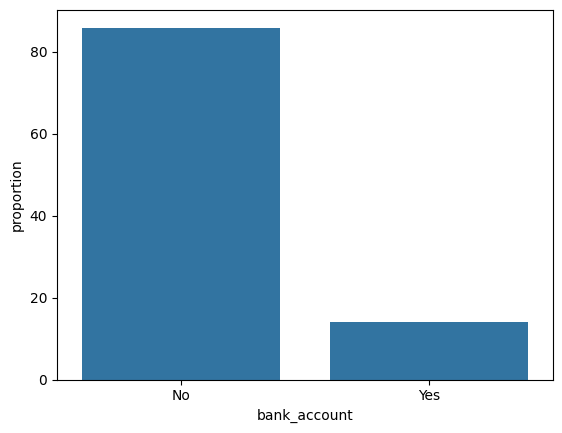

In [7]:
data = df['bank_account'].value_counts(normalize=True).mul(100).reset_index()
sns.barplot(data=data, x='bank_account', y='proportion')

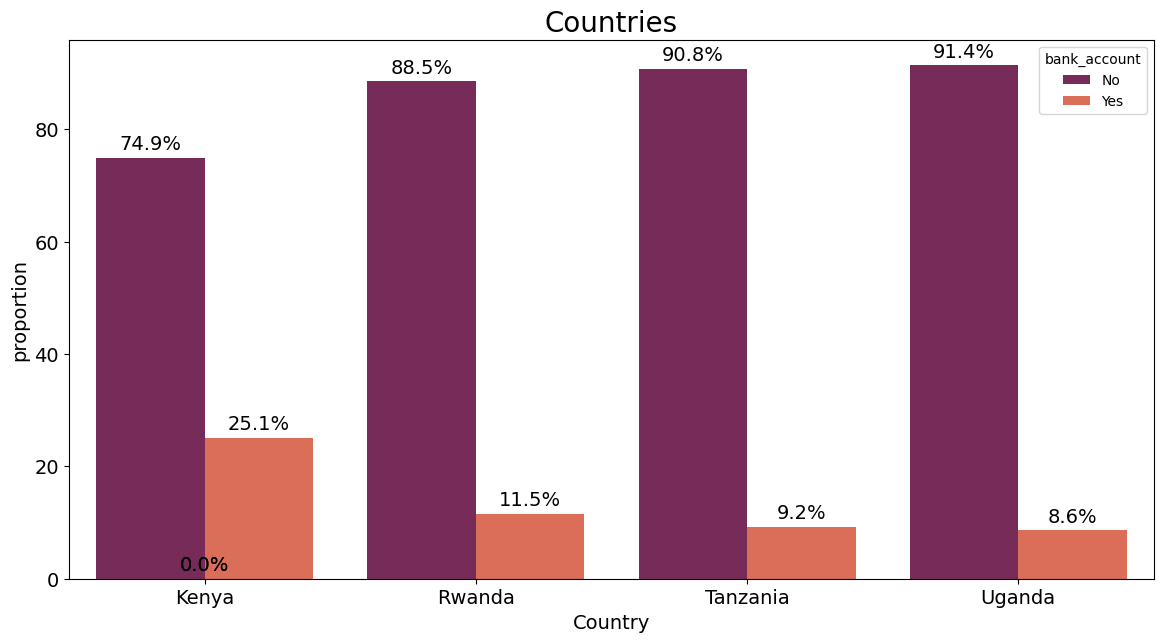

In [20]:
data = df.groupby('country')['bank_account'].value_counts(normalize=True).mul(100).reset_index()
plt.figure(figsize=(14, 7))
ax = sns.barplot(data=data, x='country', y='proportion', hue='bank_account', palette='rocket')
for p in ax.patches:
    percentage = '{:.1f}%'.format(p.get_height())
    ax.annotate(percentage,
                (p.get_x() + p.get_width() / 2., p.get_height()),  
                ha='center', 
                va='center',
                xytext=(0, 10),
                textcoords='offset points', 
                fontsize=14)

plt.title('Countries', fontsize=20)
plt.xlabel('Country', fontsize=14)
plt.ylabel('proportion', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

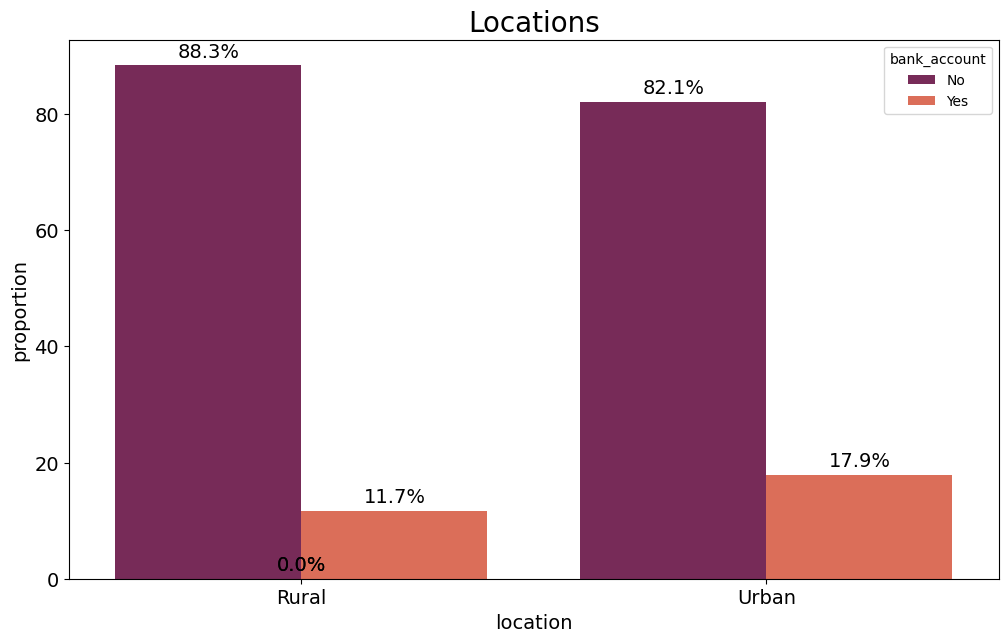

In [19]:
data = df.groupby('location_type')['bank_account'].value_counts(normalize=True).mul(100).reset_index()
plt.figure(figsize=(12, 7))
ax = sns.barplot(data=data, x='location_type', y='proportion', hue='bank_account', palette='rocket')
for p in ax.patches:
    percentage = '{:.1f}%'.format(p.get_height())
    ax.annotate(percentage,
                (p.get_x() + p.get_width() / 2., p.get_height()),  
                ha='center', 
                va='center',
                xytext=(0, 10),
                textcoords='offset points', 
                fontsize=14)

plt.title('Locations', fontsize=20)
plt.xlabel('location', fontsize=14)
plt.ylabel('proportion', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);
plt.show()

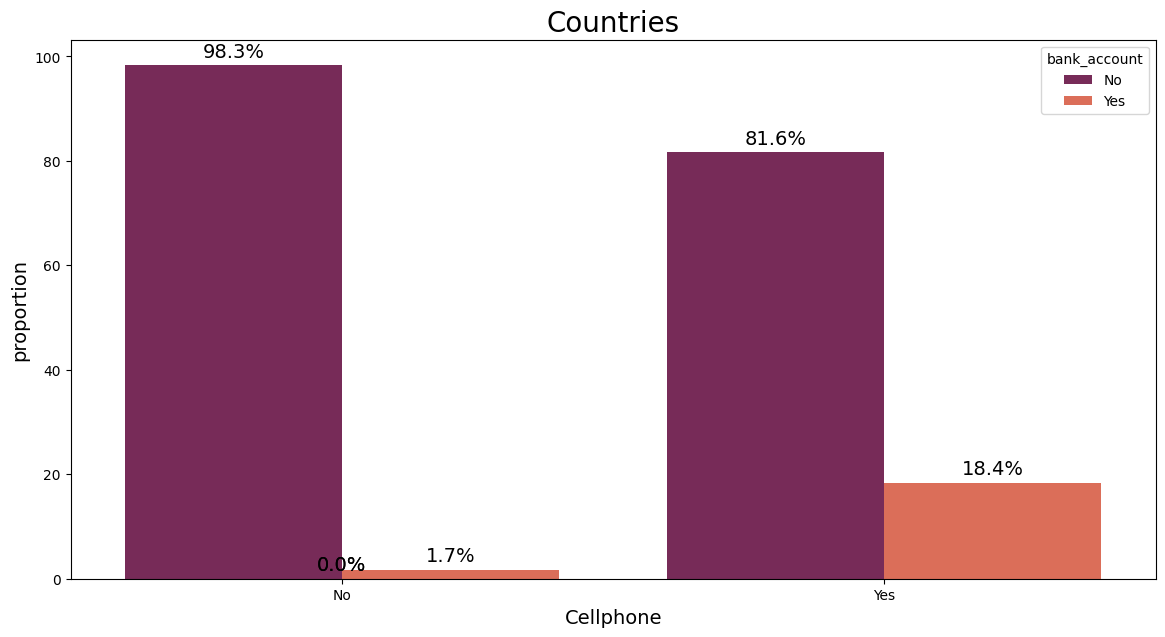

In [18]:
data = df.groupby('cellphone_access')['bank_account'].value_counts(normalize=True).mul(100).reset_index()
plt.figure(figsize=(14, 7))
ax = sns.barplot(data=data, x='cellphone_access', y='proportion', hue='bank_account', palette='rocket')
for p in ax.patches:
    percentage = '{:.1f}%'.format(p.get_height())
    ax.annotate(percentage,
                (p.get_x() + p.get_width() / 2., p.get_height()),  
                ha='center', 
                va='center',
                xytext=(0, 10),
                textcoords='offset points', 
                fontsize=14)

plt.title('Countries', fontsize=20)
plt.xlabel('Cellphone', fontsize=14)
plt.ylabel('proportion', fontsize=14)
plt.show()

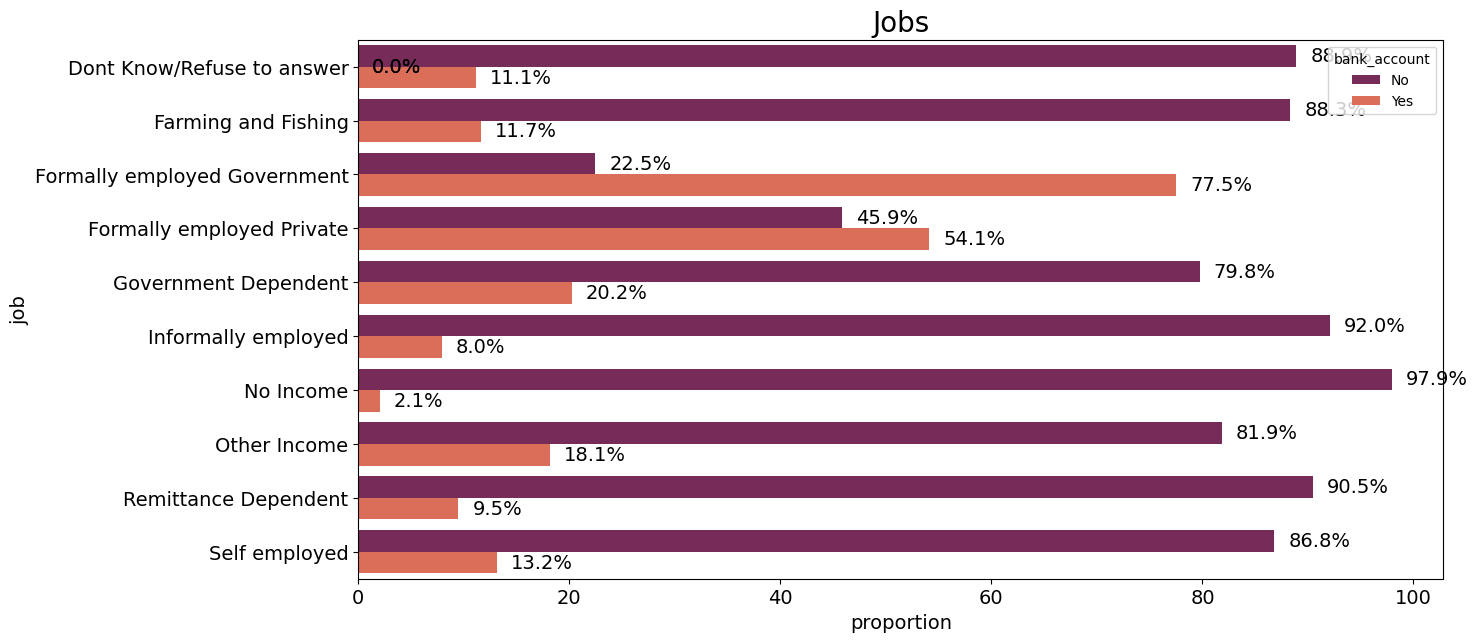

In [16]:
data = df.groupby('job_type')['bank_account'].value_counts(normalize=True).mul(100).reset_index()
plt.figure(figsize=(14, 7))
ax = sns.barplot(data=data, x='proportion', y='job_type', hue='bank_account', palette='rocket')
for p in ax.patches:
    percentage = '{:.1f}%'.format(p.get_width())
    ax.annotate(percentage,
                (p.get_width(), p.get_y() + p.get_height() / 2.),  
                ha='left', 
                va='center',
                xytext=(10, 0),
                textcoords='offset points', 
                fontsize=14)

plt.title('Jobs', fontsize=20)
plt.xlabel('proportion', fontsize=14)
plt.ylabel('job', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

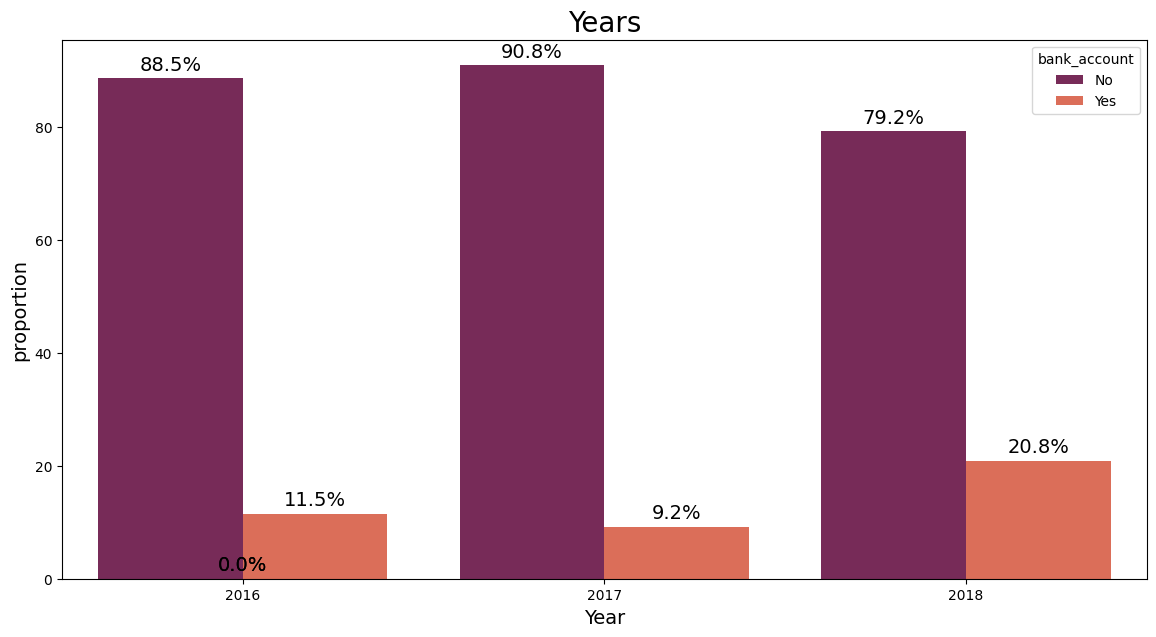

In [17]:
data = df.groupby('year')['bank_account'].value_counts(normalize=True).mul(100).reset_index()
plt.figure(figsize=(14, 7))
ax = sns.barplot(data=data, x='year', y='proportion', hue='bank_account', palette='rocket')
for p in ax.patches:
    percentage = '{:.1f}%'.format(p.get_height())
    ax.annotate(percentage,
                (p.get_x() + p.get_width() / 2., p.get_height()),  
                ha='center', 
                va='center',
                xytext=(0, 10),
                textcoords='offset points', 
                fontsize=14)

plt.title('Years', fontsize=20)
plt.xlabel('Year', fontsize=14)
plt.ylabel('proportion', fontsize=14)
plt.show()

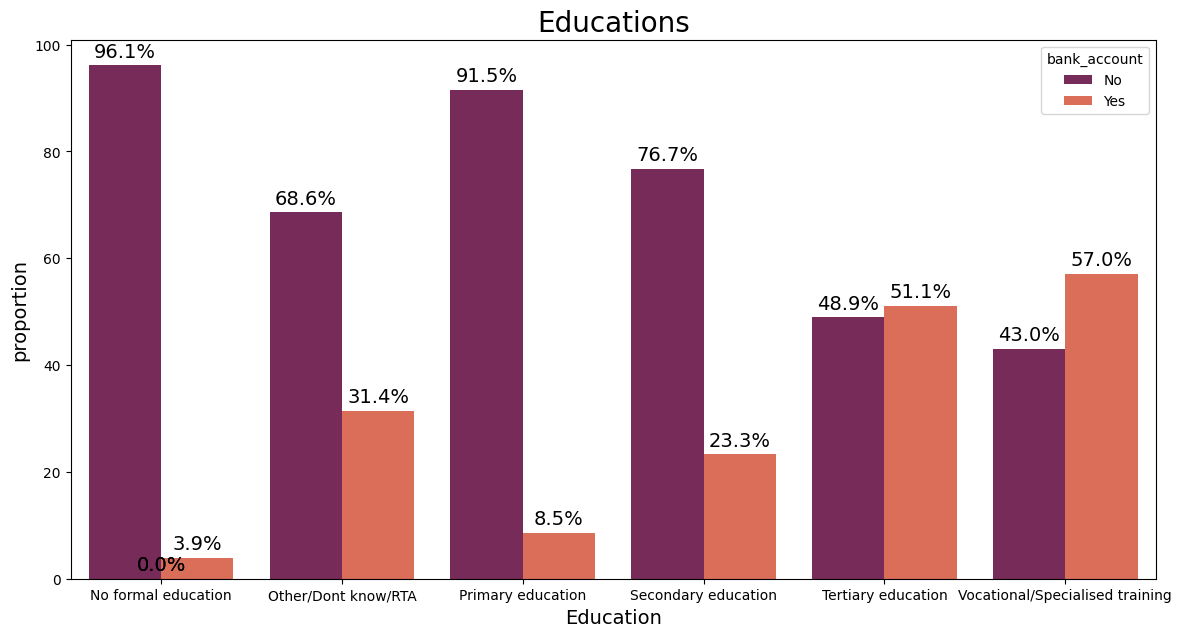

In [23]:
data = df.groupby('education_level')['bank_account'].value_counts(normalize=True).mul(100).reset_index()
plt.figure(figsize=(14, 7))
ax = sns.barplot(data=data, x='education_level', y='proportion', hue='bank_account', palette='rocket')
for p in ax.patches:
    percentage = '{:.1f}%'.format(p.get_height())
    ax.annotate(percentage,
                (p.get_x() + p.get_width() / 2., p.get_height()),  
                ha='center', 
                va='center',
                xytext=(0, 10),
                textcoords='offset points', 
                fontsize=14)

plt.title('Educations', fontsize=20)
plt.xlabel('Education', fontsize=14)
plt.ylabel('proportion', fontsize=14)
plt.show()

# Feature engineering

In [24]:
y = LabelEncoder().fit_transform(df['bank_account'])
y

array([1, 0, 1, ..., 0, 0, 0])

In [25]:
X = df.drop(columns=['uniqueid', 'bank_account'])
X

,country,year,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed
1,Kenya,2018,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent
2,Kenya,2018,Urban,Yes,5,26,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed
3,Kenya,2018,Rural,Yes,5,34,Female,Head of Household,Married/Living together,Primary education,Formally employed Private
4,Kenya,2018,Urban,No,8,26,Male,Child,Single/Never Married,Primary education,Informally employed
...,...,...,...,...,...,...,...,...,...,...,...
23519,Uganda,2018,Rural,Yes,4,48,Female,Head of Household,Divorced/Seperated,No formal education,Other Income
23520,Uganda,2018,Rural,Yes,2,27,Female,Head of Household,Single/Never Married,Secondary education,Other Income
23521,Uganda,2018,Rural,Yes,5,27,Female,Parent,Widowed,Primary education,Other Income
23522,Uganda,2018,Urban,Yes,7,30,Female,Parent,Divorced/Seperated,Secondary education,Self employed


In [26]:
X = pd.get_dummies(X)

In [27]:
numeric_columns = X.select_dtypes('int').columns.to_list()

In [28]:
sc = StandardScaler()
X[numeric_columns] = sc.fit_transform(X[numeric_columns])

In [29]:
X_train_main, X_test_main, y_train_main, y_test_main = train_test_split(X, y, test_size=0.23, stratify=y, random_state=RAND)
X_train_main_, X_val_main, y_train_main_, y_val_main = train_test_split(X_train_main, y_train_main, test_size=0.13, stratify=y_train_main, random_state=RAND)

# Training

In [38]:
models = {
    'LGBM': LGBMClassifier(random_state=RAND, is_unbalance=True),
    'XGB': XGBClassifier(random_state=RAND),
    'CatBoost': CatBoostClassifier(random_state=RAND, auto_class_weights='Balanced', verbose=False),
    'Rand For': RandomForestClassifier(random_state=RAND, class_weight='balanced'),
    'Log Reg': LogisticRegression(random_state=RAND, class_weight='balanced')
}

In [195]:
cv = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RAND)
models_keys = list(models.keys())
models_values = list(models.values())
scores = list()
for i in range(len(models)):
    to_train = models_values[i]
    fold_score = list()
    
    for fold, (train_idx, val_idx) in enumerate(cv.split(X_train_main, y_train_main)):
        X_train_, X_val_ = X_train_main.iloc[train_idx], X_train_main.iloc[val_idx]
        y_train_, y_val_ = y_train_main[train_idx], y_train_main[val_idx]
        to_train.fit(X_train_, y_train_)
        
        y_score_ = to_train.predict_proba(X_val_)
        to_append = roc_auc_score(y_val_, y_score_[:, 1])
        fold_score.append(to_append)
        
    scores.append(np.mean(fold_score))
    print(f'Model: {models_keys[i]},  score = {scores[i]}')

Model: LGBM,  score = 0.8591809453632651
Model: XGB,  score = 0.8482054142353297
Model: CatBoost,  score = 0.856445596268164
Model: Rand For,  score = 0.8026867172505355
Model: Log Reg,  score = 0.8511730751120326


# LGBM Baseline

In [31]:
meta_X = pd.DataFrame()
meta_X_test = pd.DataFrame()

In [32]:
pred_val = []
pred_score_val = []

cv = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RAND)
for fold, (train_idx, val_idx) in enumerate(cv.split(X_train_main_, y_train_main_)):
    X_train_, X_val_ = X_train_main_.iloc[train_idx], X_train_main_.iloc[val_idx]
    y_train_, y_val_ = y_train_main_[train_idx], y_train_main_[val_idx]

    model1 = LGBMClassifier(random_state=RAND, is_unbalance=True)
    model1.fit(X_train_, y_train_, verbose=0)

    y_pred_val = model1.predict(X_val_)
    y_score_val = model1.predict_proba(X_val_)

    print("Fold:", fold + 1, "ROC-AUC SCORE %.3f" % roc_auc_score(y_val_, y_score_val[:, 1]))
    print("---")

    pred_val.append(y_pred_val)
    pred_score_val.append(y_score_val)

model1.fit(X_train_main_, y_train_main_)

meta_X['lgb_base'] = np.concatenate(pred_score_val)[:, 1]
meta_X_test['lgb_base'] = model1.predict_proba(X_test_main)[:, 1]

Fold: 1 ROC-AUC SCORE 0.859
---
Fold: 2 ROC-AUC SCORE 0.853
---
Fold: 3 ROC-AUC SCORE 0.853
---
Fold: 4 ROC-AUC SCORE 0.858
---
Fold: 5 ROC-AUC SCORE 0.847
---


In [33]:
check_overfitting(model=model1, X_train=X_train_main_, y_train=y_train_main_, X_test=X_test_main, y_test=y_test_main, metric_fun=roc_auc_score)

roc_auc_score train: 0.91892
roc_auc_score test: 0.86581
delta = 6.1 %


# LGBM Tuned

In [89]:
y_train_main

array([0, 0, 0, ..., 0, 0, 0])

In [109]:
# def objective_lgb(trial, random_state):
#     lgb_params = {
#         "n_estimators": trial.suggest_categorical("n_estimators", [597]),
#         "learning_rate": trial.suggest_categorical("learning_rate", [0.007712784998233396]),
#             # 'n_estimators': trial.suggest_int('n_estimators', 300, 900),
#             # "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.3, log=True)
#         'max_depth': trial.suggest_int('max_depth', 3, 10),
#         'num_leaves': trial.suggest_int('num_leaves', 10, 1000),
#         'subsample': trial.suggest_uniform('subsample', 0.5, 1.0)
#     }
#     cv = StratifiedKFold(n_splits=N_FOLDS, random_state=RAND, shuffle=True)
#     cv_predicts = np.empty(N_FOLDS)
#     for fold, (train_idx, val_idx) in enumerate(cv.split(X_train_main, y_train_main)):
#         X_train_, X_val_ = X_train_main.iloc[train_idx], X_train_main.iloc[val_idx]
#         y_train_, y_val_ = y_train_main[train_idx], y_train_main[val_idx]
        

#         model = LGBMClassifier(**lgb_params, is_unbalance=True, random_state=RAND, metric='AUC')
#         model.fit(X_train_, y_train_, verbose=0)

#         prediction = model.predict_proba(X_val_)[:, 1]
#         cv_predicts[fold] = roc_auc_score(y_val_, prediction)

#     return np.mean(cv_predicts)

# study = optuna.create_study(direction="maximize")
# pointer = lambda trial: objective_lgb(trial, random_state=RAND)
# study.optimize(pointer, n_trials=30, show_progress_bar=True)

[I 2024-03-22 14:08:29,084] A new study created in memory with name: no-name-9c851199-bee0-44b2-b7e7-8fbb5eb54538


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2024-03-22 14:08:32,655] Trial 0 finished with value: 0.8607313842906649 and parameters: {'n_estimators': 597, 'learning_rate': 0.007712784998233396, 'max_depth': 4, 'num_leaves': 927, 'subsample': 0.5570121724703487}. Best is trial 0 with value: 0.8607313842906649.
[I 2024-03-22 14:08:41,869] Trial 1 finished with value: 0.8573616177325123 and parameters: {'n_estimators': 597, 'learning_rate': 0.007712784998233396, 'max_depth': 8, 'num_leaves': 730, 'subsample': 0.5523422665795101}. Best is trial 0 with value: 0.8607313842906649.
[I 2024-03-22 14:08:55,555] Trial 2 finished with value: 0.8538515780429503 and parameters: {'n_estimators': 597, 'learning_rate': 0.007712784998233396, 'max_depth': 9, 'num_leaves': 751, 'subsample': 0.545426554817968}. Best is trial 0 with value: 0.8607313842906649.
[I 2024-03-22 14:08:57,786] Trial 3 finished with value: 0.8550969025559383 and parameters: {'n_estimators': 597, 'learning_rate': 0.007712784998233396, 'max_depth': 3, 'num_leaves': 169, 'su

In [119]:
def objective_lgb(trial, random_state):
    lgb_params = {
        # "n_estimators": trial.suggest_categorical("n_estimators", [305]),
        # "learning_rate": trial.suggest_categorical("learning_rate", [0.013284516577128046]),
        'n_estimators': trial.suggest_int('n_estimators', 300, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'num_leaves': trial.suggest_int('num_leaves', 10, 1000),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0)
        # 'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0)
    }
    # pruning_callback = optuna.integration.LightGBMPruningCallback(
    #         trial, "l1")
    model = LGBMClassifier(**lgb_params, is_unbalance=True, random_state=RAND, metric='AUC')
    model.fit(X_train_main_, y_train_main_, verbose=0)

    preds = model.predict_proba(X_val_main)[:, 1]
    score = roc_auc_score(y_val_main, preds)
    return score

study = optuna.create_study(direction="maximize")
pointer = lambda trial: objective_lgb(trial, random_state=RAND)
study.optimize(pointer, n_trials=35, show_progress_bar=True)

[I 2024-03-22 14:15:08,411] A new study created in memory with name: no-name-f97e1bd6-c3b1-429a-b521-11d209b2d8df


  0%|          | 0/35 [00:00<?, ?it/s]

[I 2024-03-22 14:15:10,660] Trial 0 finished with value: 0.8296956982651317 and parameters: {'n_estimators': 675, 'learning_rate': 0.1047713841177904, 'max_depth': 8, 'num_leaves': 165, 'subsample': 0.9115317118463382}. Best is trial 0 with value: 0.8296956982651317.
[I 2024-03-22 14:15:12,046] Trial 1 finished with value: 0.8410336849126611 and parameters: {'n_estimators': 320, 'learning_rate': 0.11473373520076698, 'max_depth': 9, 'num_leaves': 803, 'subsample': 0.871769215553974}. Best is trial 1 with value: 0.8410336849126611.
[I 2024-03-22 14:15:15,162] Trial 2 finished with value: 0.8633932665908319 and parameters: {'n_estimators': 575, 'learning_rate': 0.004293201024714793, 'max_depth': 9, 'num_leaves': 645, 'subsample': 0.8464222863725486}. Best is trial 2 with value: 0.8633932665908319.
[I 2024-03-22 14:15:15,644] Trial 3 finished with value: 0.8664082925870562 and parameters: {'n_estimators': 653, 'learning_rate': 0.10943079409498205, 'max_depth': 3, 'num_leaves': 243, 'subsam

In [120]:
study.best_params

{'n_estimators': 634,
 'learning_rate': 0.07759034001419247,
 'max_depth': 3,
 'num_leaves': 759,
 'subsample': 0.864668774632936}

Saved:
{'n_estimators': 575,
 'learning_rate': 0.0027213754476726384,
 'max_depth': 9,
 'num_leaves': 698,
 'subsample': 0.5809036581178155,
 'colsample_bytree': 0.5010681356698323}

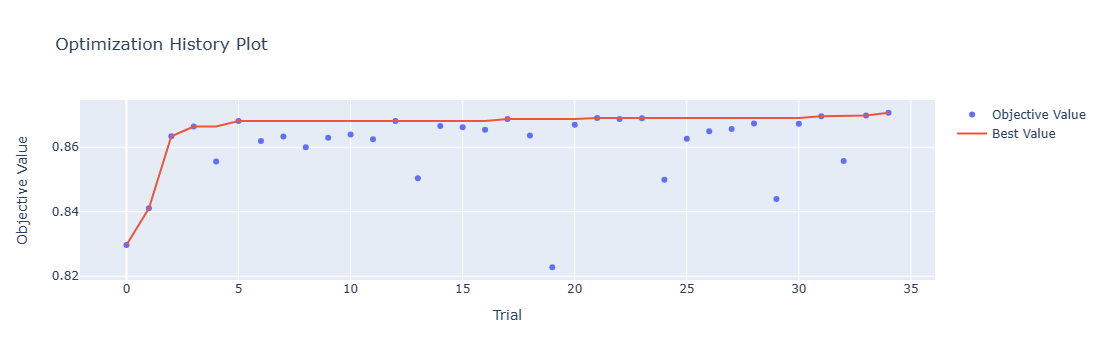

In [121]:
optuna.visualization.plot_optimization_history(study)


In [122]:
pred_val = []
pred_score_val = []

cv = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RAND)
for fold, (train_idx, val_idx) in enumerate(cv.split(X_train_main_, y_train_main_)):
    X_train_, X_val_ = X_train_main_.iloc[train_idx], X_train_main_.iloc[val_idx]
    y_train_, y_val_ = y_train_main_[train_idx], y_train_main_[val_idx]

    model2 = LGBMClassifier(**study.best_params, is_unbalance=True, random_state=RAND, metric='AUC')
    model2.fit(X_train_, y_train_, verbose=0)

    y_pred_val = model2.predict(X_val_)
    y_score_val = model2.predict_proba(X_val_)

    print("Fold:", fold + 1, "ROC-AUC SCORE %.3f" % roc_auc_score(y_val_, y_score_val[:, 1]))
    print("---")

    pred_val.append(y_pred_val)
    pred_score_val.append(y_score_val)

# обучаем модель для предсказания на test
model2.fit(X_train_main_, y_train_main_)

meta_X['lgb_tuned'] = np.concatenate(pred_score_val)[:,1]
meta_X_test['lgb_tuned'] = model2.predict_proba(X_test_main)[:,1]

Fold: 1 ROC-AUC SCORE 0.859
---
Fold: 2 ROC-AUC SCORE 0.851
---
Fold: 3 ROC-AUC SCORE 0.854
---
Fold: 4 ROC-AUC SCORE 0.856
---
Fold: 5 ROC-AUC SCORE 0.856
---


In [123]:
check_overfitting(model=model2, X_train=X_train_main, y_train=y_train_main, X_test=X_test_main, y_test=y_test_main, metric_fun=roc_auc_score)

roc_auc_score train: 0.89476
roc_auc_score test: 0.86493
delta = 3.4 %


# XGB Tuned

In [124]:
def objective_xgb(trial, random_state):
    xgb_params = {
        'n_estimators': trial.suggest_int('n_estimators', 300, 900),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        # 'num_leaves': trial.suggest_int('num_leaves', 10, 1000),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0)
    }

    model = XGBClassifier(**xgb_params, random_state=RAND, objective='binary:logistic')
    model.fit(X_train_main_, y_train_main_, eval_metric='auc', eval_set=[(X_val_main, y_val_main)], verbose=False)

    preds = model.predict_proba(X_val_main)[:, 1]
    score = roc_auc_score(y_val_main, preds)
    return score

study_xgb = optuna.create_study(direction="maximize")
pointer = lambda trial: objective_xgb(trial, random_state=RAND)
study_xgb.optimize(pointer, n_trials=35, show_progress_bar=True)

[I 2024-03-22 14:16:26,778] A new study created in memory with name: no-name-78f6c290-dbee-4f98-b1d6-5f173d14d800


  0%|          | 0/35 [00:00<?, ?it/s]

[I 2024-03-22 14:16:30,791] Trial 0 finished with value: 0.846360975290187 and parameters: {'n_estimators': 600, 'learning_rate': 0.039266989090754406, 'max_depth': 11, 'subsample': 0.5500757261812244, 'colsample_bytree': 0.9625119038814072}. Best is trial 0 with value: 0.846360975290187.
[I 2024-03-22 14:16:32,809] Trial 1 finished with value: 0.8654427398174012 and parameters: {'n_estimators': 583, 'learning_rate': 0.032249262425918336, 'max_depth': 5, 'subsample': 0.8678074895993666, 'colsample_bytree': 0.8839683301073791}. Best is trial 1 with value: 0.8654427398174012.
[I 2024-03-22 14:16:35,716] Trial 2 finished with value: 0.8282455079834912 and parameters: {'n_estimators': 483, 'learning_rate': 0.26627430251515016, 'max_depth': 13, 'subsample': 0.998293737018966, 'colsample_bytree': 0.9849522117359175}. Best is trial 1 with value: 0.8654427398174012.
[I 2024-03-22 14:16:40,146] Trial 3 finished with value: 0.8667284064582601 and parameters: {'n_estimators': 808, 'learning_rate'

In [125]:
study_xgb.best_params

{'n_estimators': 898,
 'learning_rate': 0.007865774690487755,
 'max_depth': 8,
 'subsample': 0.6631035230845164,
 'colsample_bytree': 0.6002782058072016}

Saved:
{'n_estimators': 745,
 'learning_rate': 0.02093004760601575,
 'max_depth': 4,
 'subsample': 0.815587804415079,
 'colsample_bytree': 0.9334191677923097}

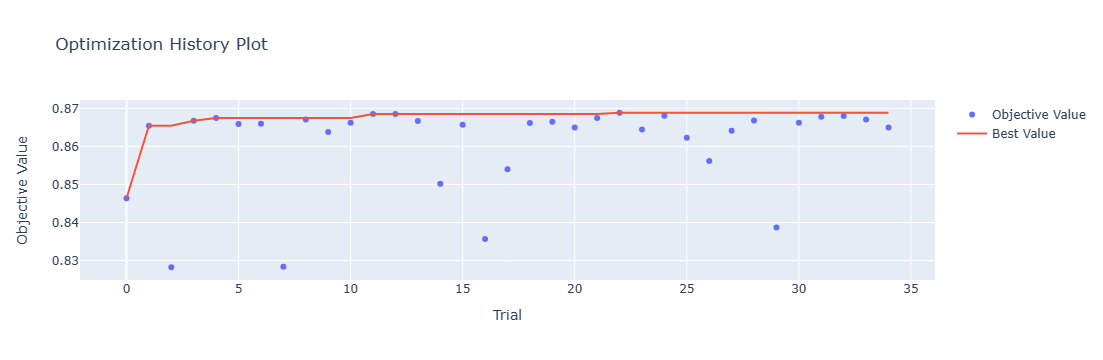

In [126]:
optuna.visualization.plot_optimization_history(study_xgb)

In [127]:
pred_val = []
pred_score_val = []

cv = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RAND)
for fold, (train_idx, val_idx) in enumerate(cv.split(X_train_main_, y_train_main_)):
    X_train_, X_val_ = X_train_main_.iloc[train_idx], X_train_main_.iloc[val_idx]
    y_train_, y_val_ = y_train_main_[train_idx], y_train_main_[val_idx]

    model3 = XGBClassifier(**study_xgb.best_params, random_state=RAND, objective='binary:logistic')
    model3.fit(X_train_, y_train_, eval_metric='auc', eval_set=[(X_val_main, y_val_main)], verbose=0)

    y_pred_val = model3.predict(X_val_)
    y_score_val = model3.predict_proba(X_val_)

    print("Fold:", fold + 1, "ROC-AUC SCORE %.3f" % roc_auc_score(y_val_, y_score_val[:, 1]))
    print("---")

    pred_val.append(y_pred_val)
    pred_score_val.append(y_score_val)

# обучаем модель для предсказания на test
model3.fit(X_train_main_, y_train_main_)

meta_X['xgb_tuned'] = np.concatenate(pred_score_val)[:,1]
meta_X_test['xgb_tuned'] = model3.predict_proba(X_test_main)[:,1]

Fold: 1 ROC-AUC SCORE 0.867
---
Fold: 2 ROC-AUC SCORE 0.864
---
Fold: 3 ROC-AUC SCORE 0.857
---
Fold: 4 ROC-AUC SCORE 0.859
---
Fold: 5 ROC-AUC SCORE 0.853
---


In [128]:
check_overfitting(model=model3, X_train=X_train_main_, y_train=y_train_main_, X_test=X_test_main, y_test=y_test_main, metric_fun=roc_auc_score)

roc_auc_score train: 0.91811
roc_auc_score test: 0.86570
delta = 6.1 %


# Catboost Baseline

In [129]:
pred_val = []
pred_score_val = []

cv = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RAND)
for fold, (train_idx, val_idx) in enumerate(cv.split(X_train_main_, y_train_main_)):
    X_train_, X_val_ = X_train_main_.iloc[train_idx], X_train_main_.iloc[val_idx]
    y_train_, y_val_ = y_train_main_[train_idx], y_train_main_[val_idx]

    model4 = CatBoostClassifier(random_state=RAND, auto_class_weights='Balanced', verbose=False)
    model4.fit(X_train_,
              y_train_,
              verbose=False)

    y_pred_val = model4.predict(X_val_)
    y_score_val = model4.predict_proba(X_val_)

    print("Fold:", fold + 1, "ROC-AUC SCORE %.3f" % roc_auc_score(y_val_, y_score_val[:, 1]))
    print("---")

    # holdout list
    pred_val.append(y_pred_val)
    pred_score_val.append(y_score_val)

# обучаем модель для предсказания на test
model4.fit(X_train_main_, y_train_main_)

meta_X['cb_base'] = np.concatenate(pred_score_val)[:,1]
meta_X_test['cb_base'] = model4.predict_proba(X_test_main)[:,1]

Fold: 1 ROC-AUC SCORE 0.857
---
Fold: 2 ROC-AUC SCORE 0.852
---
Fold: 3 ROC-AUC SCORE 0.853
---
Fold: 4 ROC-AUC SCORE 0.852
---
Fold: 5 ROC-AUC SCORE 0.848
---


In [130]:
check_overfitting(model=model4, X_train=X_train_main_, y_train=y_train_main_, X_test=X_test_main, y_test=y_test_main, metric_fun=roc_auc_score)

roc_auc_score train: 0.93292
roc_auc_score test: 0.86214
delta = 8.2 %


# Random Forest Tuned

In [75]:
def objective_rf(trial, random_state):
    rf_params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 900),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        'bootstrap': trial.suggest_categorical("bootstrap", [True]),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'max_samples': trial.suggest_float('max_samples', 0.3, 0.99),
        'max_features': trial.suggest_categorical("max_features", ['sqrt', 'log2']),
        'n_jobs': trial.suggest_categorical("n_jobs", [-1])
    }

    model = RandomForestClassifier(**rf_params, random_state=RAND, class_weight='balanced')
    model.fit(X_train_main_, y_train_main_)

    preds = model.predict_proba(X_val_main)[:, 1]
    score = roc_auc_score(y_val_main, preds)
    return score

study_rf = optuna.create_study(direction="maximize")
pointer = lambda trial: objective_rf(trial, random_state=RAND)
study_rf.optimize(pointer, n_trials=40, show_progress_bar=True)

[I 2024-03-22 09:34:17,744] A new study created in memory with name: no-name-3094db72-9e1e-404b-8e94-108d2ec85fc1


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2024-03-22 09:34:19,550] Trial 0 finished with value: 0.8673984122351988 and parameters: {'n_estimators': 654, 'max_depth': 11, 'bootstrap': True, 'min_samples_leaf': 7, 'min_samples_split': 2, 'max_samples': 0.7748291825290545, 'max_features': 'sqrt', 'n_jobs': -1}. Best is trial 0 with value: 0.8673984122351988.
[I 2024-03-22 09:34:20,232] Trial 1 finished with value: 0.8666033387132316 and parameters: {'n_estimators': 222, 'max_depth': 14, 'bootstrap': True, 'min_samples_leaf': 6, 'min_samples_split': 5, 'max_samples': 0.6904538650111491, 'max_features': 'sqrt', 'n_jobs': -1}. Best is trial 0 with value: 0.8673984122351988.
[I 2024-03-22 09:34:21,977] Trial 2 finished with value: 0.8524647279180984 and parameters: {'n_estimators': 713, 'max_depth': 5, 'bootstrap': True, 'min_samples_leaf': 5, 'min_samples_split': 17, 'max_samples': 0.7643923939518127, 'max_features': 'sqrt', 'n_jobs': -1}. Best is trial 0 with value: 0.8673984122351988.
[I 2024-03-22 09:34:24,224] Trial 3 finishe

In [76]:
study_rf.best_params

{'n_estimators': 438,
 'max_depth': 12,
 'bootstrap': True,
 'min_samples_leaf': 9,
 'min_samples_split': 10,
 'max_samples': 0.47472594740305935,
 'max_features': 'log2',
 'n_jobs': -1}

Saved:
{'n_estimators': 730,
 'max_depth': 13,
 'bootstrap': True,
 'min_samples_leaf': 7,
 'min_samples_split': 14,
 'max_samples': 0.8053623789842076,
 'max_features': 'sqrt',
 'n_jobs': -1}

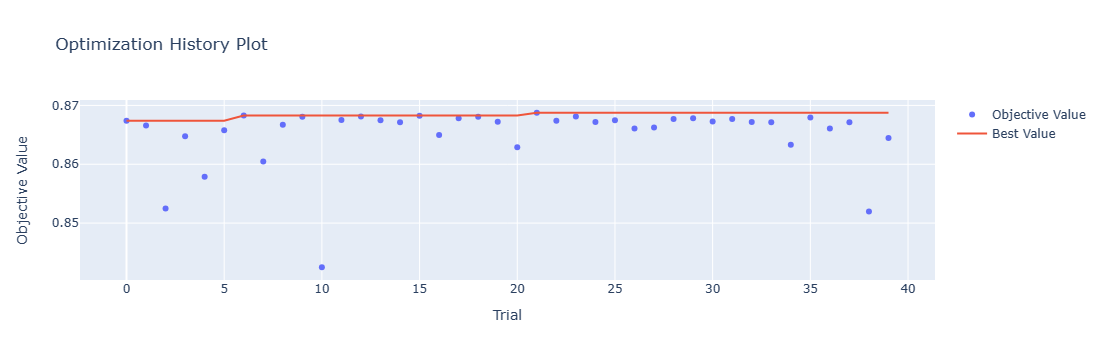

In [77]:
optuna.visualization.plot_optimization_history(study_rf)

In [78]:
pred_val = []
pred_score_val = []

cv = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RAND)
for fold, (train_idx, val_idx) in enumerate(cv.split(X_train_main_, y_train_main_)):
    X_train_, X_val_ = X_train_main_.iloc[train_idx], X_train_main_.iloc[val_idx]
    y_train_, y_val_ = y_train_main_[train_idx], y_train_main_[val_idx]

    model5 = RandomForestClassifier(**study_rf.best_params, random_state=RAND, class_weight='balanced')
    model5.fit(X_train_, y_train_)

    y_pred_val = model5.predict(X_val_)
    y_score_val = model5.predict_proba(X_val_)

    print("Fold:", fold + 1, "ROC-AUC SCORE %.3f" % roc_auc_score(y_val_, y_score_val[:, 1]))
    print("---")

    pred_val.append(y_pred_val)
    pred_score_val.append(y_score_val)

# обучаем модель для предсказания на test
model5.fit(X_train_main_, y_train_main_)

meta_X['xgb_tuned'] = np.concatenate(pred_score_val)[:,1]
meta_X_test['xgb_tuned'] = model5.predict_proba(X_test_main)[:,1]

Fold: 1 ROC-AUC SCORE 0.869
---
Fold: 2 ROC-AUC SCORE 0.860
---
Fold: 3 ROC-AUC SCORE 0.856
---
Fold: 4 ROC-AUC SCORE 0.858
---
Fold: 5 ROC-AUC SCORE 0.853
---


In [79]:
check_overfitting(model=model5, X_train=X_train_main_, y_train=y_train_main_, X_test=X_test_main, y_test=y_test_main, metric_fun=roc_auc_score)

roc_auc_score train: 0.88428
roc_auc_score test: 0.86563
delta = 2.2 %


# Logistic Regression

In [80]:
pred_val = []
pred_score_val = []

cv = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RAND)
for fold, (train_idx, val_idx) in enumerate(cv.split(X_train_main_, y_train_main_)):
    X_train_, X_val_ = X_train_main_.iloc[train_idx], X_train_main_.iloc[val_idx]
    y_train_, y_val_ = y_train_main_[train_idx], y_train_main_[val_idx]

    model6 = LogisticRegression(class_weight='balanced', random_state=RAND)
    model6.fit(X_train_, y_train_)

    y_pred_val = model6.predict(X_val_)
    y_score_val = model6.predict_proba(X_val_)

    print("Fold:", fold + 1, "ROC-AUC SCORE %.3f" % roc_auc_score(y_val_, y_score_val[:, 1]))
    print("---")

    # holdout list
    pred_val.append(y_pred_val)
    pred_score_val.append(y_score_val)

# обучаем модель для предсказания на test
model6.fit(X_train_main_, y_train_main_)

meta_X['cb_base'] = np.concatenate(pred_score_val)[:,1]
meta_X_test['cb_base'] = model6.predict_proba(X_test_main)[:,1]

Fold: 1 ROC-AUC SCORE 0.856
---
Fold: 2 ROC-AUC SCORE 0.851
---
Fold: 3 ROC-AUC SCORE 0.844
---
Fold: 4 ROC-AUC SCORE 0.847
---
Fold: 5 ROC-AUC SCORE 0.844
---


In [81]:
check_overfitting(model=model6, X_train=X_train_main_, y_train=y_train_main_, X_test=X_test_main, y_test=y_test_main, metric_fun=roc_auc_score)

roc_auc_score train: 0.85112
roc_auc_score test: 0.85501
delta = 0.5 %


# Voting

In [82]:
clb_lg1 = CalibratedClassifierCV(base_estimator=model1, method='isotonic', cv=3)
clb_lg2 = CalibratedClassifierCV(base_estimator=model2, method='isotonic', cv=3)
clb_xg1 = CalibratedClassifierCV(base_estimator=model3, method='isotonic', cv=3)
clb_cb1 = CalibratedClassifierCV(base_estimator=model4, method='isotonic', cv=3)
clb_rf1 = CalibratedClassifierCV(base_estimator=model5, method='isotonic', cv=3)
clb_lr1 = CalibratedClassifierCV(base_estimator=model6, method='isotonic', cv=3)

In [83]:
vt_clf = VotingClassifier(estimators=[('lg1', clb_lg1), ('lg2', clb_lg2), ('xg1', clb_xg1), ('cb1', clb_cb1), ('rf1', clb_rf1), ('lr1', clb_lr1)], voting='soft')
vt_clf.fit(X_train_main_, y_train_main_)

VotingClassifier(estimators=[('lg1',
                              CalibratedClassifierCV(base_estimator=LGBMClassifier(is_unbalance=True,
                                                                                   random_state=10),
                                                     cv=3, method='isotonic')),
                             ('lg2',
                              CalibratedClassifierCV(base_estimator=LGBMClassifier(colsample_bytree=0.9037652295592555,
                                                                                   is_unbalance=True,
                                                                                   learning_rate=0.011678935028593318,
                                                                                   max_depth=9,
                                                                                   metric='AUC',
                                                                                   n_estimators=839,
                                                                                   num_leaves...
                              CalibratedClassifierCV(base_estimator=RandomForestClassifier(class_weight='balanced',
                                                                                           max_depth=12,
                                                                                           max_features='log2',
                                                                                           max_samples=0.47472594740305935,
                                                                                           min_samples_leaf=9,
                                                                                           min_samples_split=10,
                                                                                           n_estimators=438,
                                                                                           n_jobs=-1,
                                                                                           random_state=10),
                                                     cv=3, method='isotonic')),
                             ('lr1',
                              CalibratedClassifierCV(base_estimator=LogisticRegression(class_weight='balanced',
                                                                                       random_state=10),
                                                     cv=3,
                                                     method='isotonic'))],
                 voting='soft')

In [84]:
y_predicted = vt_clf.predict(X_test_main)
y_score = vt_clf.predict_proba(X_test_main)

In [85]:
metrics = get_metrics_classification(y_test_main, y_predicted, y_score, name='VotingClassifier_soft')
metrics

,model,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
0,VotingClassifier_soft,0.888006,0.868215,0.729412,0.325459,0.450091,0.278353


In [86]:
check_overfitting(model=vt_clf, X_train=X_train_main_, X_test=X_test_main, y_train=y_train_main_, y_test=y_test_main, metric_fun=roc_auc_score)

roc_auc_score train: 0.90540
roc_auc_score test: 0.86821
delta = 4.3 %


# Combining

нужно переобучать для правильного meta_X_test

In [90]:
st_clf = KNeighborsClassifier()
st_clf.fit(meta_X, y_train_main_)

KNeighborsClassifier()

In [91]:
y_predicted = st_clf.predict(meta_X_test)
y_score = st_clf.predict_proba(meta_X_test)

In [94]:
metrics = pd.concat([metrics, get_metrics_classification(y_test_main, y_predicted, y_score, name='Hand Stacking KNN')])
metrics

,model,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
0,VotingClassifier_soft,0.888006,0.868215,0.729412,0.325459,0.450091,0.278353
0,Hand Stacking KNN,0.843837,0.487715,0.097087,0.013123,0.023121,2.743805


In [96]:
st_clf = LogisticRegression(random_state=RAND, class_weight='balanced')
st_clf.fit(meta_X, y_train_main_)

LogisticRegression(class_weight='balanced', random_state=10)

In [97]:
y_predicted = st_clf.predict(meta_X_test)
y_score = st_clf.predict_proba(meta_X_test)

In [98]:
metrics = pd.concat([metrics, get_metrics_classification(y_test_main, y_predicted, y_score, name='Hand Stacking Log Reg')])
metrics

,model,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
0,VotingClassifier_soft,0.888006,0.868215,0.729412,0.325459,0.450091,0.278353
0,Hand Stacking KNN,0.843837,0.487715,0.097087,0.013123,0.023121,2.743805
0,Hand Stacking Log Reg,0.403807,0.313105,0.068929,0.258530,0.108840,0.697226


# Stacking

In [30]:
estimators = list()
estimators.append(('LGBM Baseline', LGBMClassifier(random_state=RAND, is_unbalance=True)))
estimators.append(('LGBM Tuned', LGBMClassifier(**study.best_params, is_unbalance=True, random_state=RAND, metric='AUC')))
estimators.append(('XGB Tuned', XGBClassifier(**study_xgb.best_params, random_state=RAND, objective='binary:logistic')))
estimators.append(('Catboost Baseline', CatBoostClassifier(random_state=RAND, auto_class_weights='Balanced', verbose=False)))
estimators.append(('Random Forest Tuned', RandomForestClassifier(**study_rf.best_params, random_state=RAND, class_weight='balanced')))
estimators.append(('Logistic Regression', LogisticRegression(class_weight='balanced', random_state=RAND)))
meta_model = KNeighborsClassifier()

NameError: name 'study' is not defined

In [101]:
SC = StackingClassifier(estimators=estimators, final_estimator=meta_model, cv=5)
SC.fit(X_train_main_, y_train_main_)

StackingClassifier(cv=5,
                   estimators=[('LGBM Baseline',
                                LGBMClassifier(is_unbalance=True,
                                               random_state=10)),
                               ('LGBM Tuned',
                                LGBMClassifier(colsample_bytree=0.9037652295592555,
                                               is_unbalance=True,
                                               learning_rate=0.011678935028593318,
                                               max_depth=9, metric='AUC',
                                               n_estimators=839, num_leaves=10,
                                               random_state=10,
                                               subsample=0.6513626864817773)),
                               ('XGB Tuned',
                                XGBClassifier(b...
                                <catboost.core.CatBoostClassifier object at 0x000002038223F5F0>),
                               ('Random Forest Tuned',
                                RandomForestClassifier(class_weight='balanced',
                                                       max_depth=12,
                                                       max_features='log2',
                                                       max_samples=0.47472594740305935,
                                                       min_samples_leaf=9,
                                                       min_samples_split=10,
                                                       n_estimators=438,
                                                       n_jobs=-1,
                                                       random_state=10)),
                               ('Logistic Regression',
                                LogisticRegression(class_weight='balanced',
                                                   random_state=10))],
                   final_estimator=KNeighborsClassifier())

In [115]:
y_pred = SC.predict(X_test_main)
y_score = SC.predict_proba(X_test_main)

In [116]:
metrics = pd.concat([metrics, get_metrics_classification(y_test_main, y_pred, y_score, name='Auto Stacking KNN')])
metrics

,model,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
0,VotingClassifier_soft,0.888006,0.868215,0.729412,0.325459,0.450091,0.278353
0,Hand Stacking KNN,0.843837,0.487715,0.097087,0.013123,0.023121,2.743805
0,Hand Stacking Log Reg,0.403807,0.313105,0.068929,0.258530,0.108840,0.697226
0,Auto Stacking KNN,0.879320,0.782404,0.605825,0.409449,0.488645,1.624579


In [117]:
check_overfitting(model=SC, X_train=X_train_main_, X_test=X_test_main, y_train=y_train_main_, y_test=y_test_main, metric_fun=roc_auc_score)

roc_auc_score train: 0.81055
roc_auc_score test: 0.78240
delta = 3.6 %


In [106]:
estimators = list()
estimators.append(('LGBM Baseline', LGBMClassifier(random_state=RAND, is_unbalance=True)))
estimators.append(('LGBM Tuned', LGBMClassifier(**study.best_params, is_unbalance=True, random_state=RAND, metric='AUC')))
estimators.append(('XGB Tuned', XGBClassifier(**study_xgb.best_params, random_state=RAND, objective='binary:logistic')))
estimators.append(('Catboost Baseline', CatBoostClassifier(random_state=RAND, auto_class_weights='Balanced', verbose=False)))
estimators.append(('Random Forest Tuned', RandomForestClassifier(**study_rf.best_params, random_state=RAND, class_weight='balanced')))
estimators.append(('Logistic Regression', LogisticRegression(class_weight='balanced', random_state=RAND)))
meta_model = LogisticRegression(class_weight='balanced', random_state=RAND) # Stacking_sklearn2

In [107]:
SC2 = StackingClassifier(estimators=estimators, final_estimator=meta_model, cv=5)
SC2.fit(X_train_main_, y_train_main_)

StackingClassifier(cv=5,
                   estimators=[('LGBM Baseline',
                                LGBMClassifier(is_unbalance=True,
                                               random_state=10)),
                               ('LGBM Tuned',
                                LGBMClassifier(colsample_bytree=0.9037652295592555,
                                               is_unbalance=True,
                                               learning_rate=0.011678935028593318,
                                               max_depth=9, metric='AUC',
                                               n_estimators=839, num_leaves=10,
                                               random_state=10,
                                               subsample=0.6513626864817773)),
                               ('XGB Tuned',
                                XGBClassifier(b...
                                RandomForestClassifier(class_weight='balanced',
                                                       max_depth=12,
                                                       max_features='log2',
                                                       max_samples=0.47472594740305935,
                                                       min_samples_leaf=9,
                                                       min_samples_split=10,
                                                       n_estimators=438,
                                                       n_jobs=-1,
                                                       random_state=10)),
                               ('Logistic Regression',
                                LogisticRegression(class_weight='balanced',
                                                   random_state=10))],
                   final_estimator=LogisticRegression(class_weight='balanced',
                                                      random_state=10))

In [118]:
y_pred = SC2.predict(X_test_main)
y_score = SC2.predict_proba(X_test_main)

In [119]:
metrics = pd.concat([metrics, get_metrics_classification(y_test_main, y_pred, y_score, name='Auto Stacking Log Reg')])
metrics

,model,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
0,VotingClassifier_soft,0.888006,0.868215,0.729412,0.325459,0.450091,0.278353
0,Hand Stacking KNN,0.843837,0.487715,0.097087,0.013123,0.023121,2.743805
0,Hand Stacking Log Reg,0.403807,0.313105,0.068929,0.258530,0.108840,0.697226
0,Auto Stacking KNN,0.879320,0.782404,0.605825,0.409449,0.488645,1.624579
0,Auto Stacking Log Reg,0.792645,0.867892,0.384021,0.782152,0.515125,0.458712


# Blending

In [120]:
from sklearn.base import BaseEstimator, ClassifierMixin


class BlendingClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, models, ens_model):
        """
        models - базовые модели для стекинга
        ens_model - мета-модель
        """
        self.models = models
        self.ens_model = ens_model

    def fit(self,
            X: pd.DataFrame,
            y: pd.Series,
            test_size: float = 0.15,
            random_state: int = 10):
        """
        Обучение ансамбля моделей
        """
        X_train, X_val, y_train, y_val = train_test_split(
            X, y, stratify=y, test_size=test_size, random_state=random_state)

        # список с новыми признаками на validation
        meta_X = list()

        for model in self.models:
            # обучение на train датасете
            model.fit(X_train, y_train)
            # ответы на validation выборке
            yhat = model.predict(X_val)
            # преобразование в столбец
            yhat = yhat.reshape(len(yhat), 1)
            # запись в новый датасет
            meta_X.append(yhat)

        meta_X = np.hstack(meta_X)
        # обучение мета-алгоритма
        self.ens_model.fit(meta_X, y_val)
        return self

    def predict(self, X: pd.DataFrame) -> np.array:
        """
        получение прогнозов - классов
        """
        meta_X = list()
        
        for model in self.models:
            # ответы на test выборке
            yhat = model.predict(X)      
            yhat = yhat.reshape(len(yhat), 1)
            meta_X.append(yhat)
        meta_X = np.hstack(meta_X)
        return self.ens_model.predict(meta_X)

    def predict_proba(self, X: pd.DataFrame) -> np.array:
        """
        получение прогнозов - вероятностей
        """
        meta_X = list()
        
        for model in self.models:
            # ответы на test выборке
            yhat = model.predict(X)
            yhat = yhat.reshape(len(yhat), 1)
            meta_X.append(yhat)
        meta_X = np.hstack(meta_X)
        
        return self.ens_model.predict_proba(meta_X)

In [121]:
clb_lg1 = CalibratedClassifierCV(base_estimator=model1, method='isotonic', cv=3)
clb_lg2 = CalibratedClassifierCV(base_estimator=model2, method='isotonic', cv=3)
clb_xg1 = CalibratedClassifierCV(base_estimator=model3, method='isotonic', cv=3)
clb_cb1 = CalibratedClassifierCV(base_estimator=model4, method='isotonic', cv=3)
clb_rf1 = CalibratedClassifierCV(base_estimator=model5, method='isotonic', cv=3)
clb_lr1 = CalibratedClassifierCV(base_estimator=model6, method='isotonic', cv=3)
models = [clb_lg1, clb_lg2, clb_xg1, clb_cb1, clb_rf1, clb_lr1]
meta_model = KNeighborsClassifier()

In [122]:
blended = BlendingClassifier(models, meta_model)
blended.fit(X=X_train_main_, y=y_train_main_, random_state=RAND)

BlendingClassifier(ens_model=KNeighborsClassifier(),
                   models=[CalibratedClassifierCV(base_estimator=LGBMClassifier(is_unbalance=True,
                                                                                random_state=10),
                                                  cv=3, method='isotonic'),
                           CalibratedClassifierCV(base_estimator=LGBMClassifier(colsample_bytree=0.9037652295592555,
                                                                                is_unbalance=True,
                                                                                learning_rate=0.011678935028593318,
                                                                                max_depth=9,
                                                                                metric='AUC',
                                                                                n_estimator...
                           CalibratedClassifierCV(base_estimator=RandomForestClassifier(class_weight='balanced',
                                                                                        max_depth=12,
                                                                                        max_features='log2',
                                                                                        max_samples=0.47472594740305935,
                                                                                        min_samples_leaf=9,
                                                                                        min_samples_split=10,
                                                                                        n_estimators=438,
                                                                                        n_jobs=-1,
                                                                                        random_state=10),
                                                  cv=3, method='isotonic'),
                           CalibratedClassifierCV(base_estimator=LogisticRegression(class_weight='balanced',
                                                                                    random_state=10),
                                                  cv=3, method='isotonic')])

In [123]:
y_pred = blended.predict(X_test_main)
y_score = blended.predict_proba(X_test_main)

In [124]:
metrics = pd.concat([metrics, get_metrics_classification(y_test_main, y_pred, y_score, name='Blending KNN')])
metrics

,model,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
0,VotingClassifier_soft,0.888006,0.868215,0.729412,0.325459,0.450091,0.278353
0,Hand Stacking KNN,0.843837,0.487715,0.097087,0.013123,0.023121,2.743805
0,Hand Stacking Log Reg,0.403807,0.313105,0.068929,0.258530,0.108840,0.697226
0,Auto Stacking KNN,0.879320,0.782404,0.605825,0.409449,0.488645,1.624579
0,Auto Stacking Log Reg,0.792645,0.867892,0.384021,0.782152,0.515125,0.458712
0,Blending KNN,0.862687,0.659287,0.585586,0.085302,0.148912,0.421638


In [125]:
clb_lg1 = CalibratedClassifierCV(base_estimator=model1, method='isotonic', cv=3)
clb_lg2 = CalibratedClassifierCV(base_estimator=model2, method='isotonic', cv=3)
clb_xg1 = CalibratedClassifierCV(base_estimator=model3, method='isotonic', cv=3)
clb_cb1 = CalibratedClassifierCV(base_estimator=model4, method='isotonic', cv=3)
clb_rf1 = CalibratedClassifierCV(base_estimator=model5, method='isotonic', cv=3)
clb_lr1 = CalibratedClassifierCV(base_estimator=model6, method='isotonic', cv=3)
models = [clb_lg1, clb_lg2, clb_xg1, clb_cb1, clb_rf1, clb_lr1]
meta_model = LogisticRegression(class_weight='balanced', random_state=RAND)

In [126]:
blended = BlendingClassifier(models, meta_model)
blended.fit(X=X_train_main_, y=y_train_main_, random_state=RAND)

BlendingClassifier(ens_model=LogisticRegression(class_weight='balanced',
                                                random_state=10),
                   models=[CalibratedClassifierCV(base_estimator=LGBMClassifier(is_unbalance=True,
                                                                                random_state=10),
                                                  cv=3, method='isotonic'),
                           CalibratedClassifierCV(base_estimator=LGBMClassifier(colsample_bytree=0.9037652295592555,
                                                                                is_unbalance=True,
                                                                                learning_rate=0.011678935028593318...
                           CalibratedClassifierCV(base_estimator=RandomForestClassifier(class_weight='balanced',
                                                                                        max_depth=12,
                                                                                        max_features='log2',
                                                                                        max_samples=0.47472594740305935,
                                                                                        min_samples_leaf=9,
                                                                                        min_samples_split=10,
                                                                                        n_estimators=438,
                                                                                        n_jobs=-1,
                                                                                        random_state=10),
                                                  cv=3, method='isotonic'),
                           CalibratedClassifierCV(base_estimator=LogisticRegression(class_weight='balanced',
                                                                                    random_state=10),
                                                  cv=3, method='isotonic')])

In [127]:
y_pred = blended.predict(X_test_main)
y_score = blended.predict_proba(X_test_main)

In [128]:
metrics = pd.concat([metrics, get_metrics_classification(y_test_main, y_pred, y_score, name='Blending Log Reg')])
metrics

,model,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
0,VotingClassifier_soft,0.888006,0.868215,0.729412,0.325459,0.450091,0.278353
0,Hand Stacking KNN,0.843837,0.487715,0.097087,0.013123,0.023121,2.743805
0,Hand Stacking Log Reg,0.403807,0.313105,0.068929,0.258530,0.108840,0.697226
0,Auto Stacking KNN,0.879320,0.782404,0.605825,0.409449,0.488645,1.624579
0,Auto Stacking Log Reg,0.792645,0.867892,0.384021,0.782152,0.515125,0.458712
0,Blending KNN,0.862687,0.659287,0.585586,0.085302,0.148912,0.421638
0,Blending Log Reg,0.887082,0.684869,0.665208,0.398950,0.498769,0.575834


# Test submission

In [310]:
test = pd.read_csv('../data/kaggle/affrica_fin_incl/Test.csv')
checker = test.copy()
checker.drop(columns='uniqueid', inplace=True)
checker = pd.get_dummies(checker)
checker[numeric_columns] = sc.transform(checker[numeric_columns])

In [315]:
test['bank_account'] = model6.predict(checker)
submission = pd.DataFrame({"uniqueid": test["uniqueid"] + " x " + test["country"],
                           "bank_account": test.bank_account})
submission.to_csv('6_sumb.csv', index = False)

In [312]:
metrics_test

,model,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
0,LGBM Baseline,0.872875,0.799159,0.738255,0.150892,0.250569,0.385490
0,LGBM Tuned,0.880410,0.847495,0.772277,0.213992,0.335124,0.315372
0,XGB Tuned,0.861476,0.848149,0.875000,0.019204,0.037584,0.479110
0,Catboost Baseline,0.872295,0.838464,0.854167,0.112483,0.198788,0.377549
0,Rand For Tuned,0.883114,0.855856,0.632479,0.406036,0.494570,0.332283
0,Log Reg Baseline,0.626352,0.847655,0.257740,0.879287,0.398632,0.662171
